In [5]:
from TexSoup import TexSoup
import os
import re
import numpy as np
from nltk.tokenize import word_tokenize
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

if not os.path.isdir('temp'):
    os.mkdir('temp')
    
def clean(t):
    # get rid of otherthings                
    t = re.sub(r'\\label{.*?}\ *', '', t)
    t = re.sub(r'\\cite{.*?}\ *', '', t)
    t = re.sub(r'ref{.*?}\ *', '', t)
    t = re.sub(r'\$.*?\$\ *', '', t)
    t = t.replace('Fig.~',' ')
    t = t.replace('Eq.',' ')
    # get rid of fancy styles using detex

    with open('temp/in.tex','w') as f:
        f.write(t)
    os.system('detex temp/in.tex > temp/out.txt')
    with open('temp/out.txt') as f:
        t = f.read()
    return t

In [6]:
path ='data/tex/'

In [7]:
# get sections
pattern = re.compile(r'[{](.*)[}]', re.S)
main_file_path = path + 'EvoTree-VIS-2015.tex'
with open(main_file_path) as f: 
    main = f.readlines()
with open(main_file_path) as f: 
    text = f.read()
info = []
for s in main:
    if  '\\input' in s:
        if s[0] != '%':
            subtitle = re.findall(pattern, s)[0].split('.')[0]
            p = path + subtitle + '.tex'
            with open(p) as f: 
                paragraph = '\n' + f.read() + '\n'
            info.append((subtitle,paragraph))
    
# deal with abstrucat
final = []
t = ''
take = False
abstract = info[0][1]
for s in abstract.split('\n'):
    if 'begin{' in s:
        take = True
        name = re.findall(pattern, s)[0]
    elif 'end{' in s:
        take = False
        final.append((name,clean(t)))
    else:
        if take and len(s) > 0:
            if s[0] != '%':
                t = t +'\n'+ s
                
#deal with other parts
for i in range(1,len(info)):
    para = info[i][1]
    t = ''
    take = True
    for s in para.split('\n'):
        if ('begin{figure' in s)  or ('begin{eqnarray' in s)  or('begin{table' in s) or ('begin{equa' in s):
            take = False
        elif ('end{figure' in s)  or ('end{eqnarray' in s)  or ('end{table' in s) or  ('end{equa' in s):
            take = True
        else:
            if take and len(s) > 0:
                if s[0] != '%':
                    t = t +'\n'+ s

    final.append((info[i][0],clean(t)))

In [8]:
# tokenize & get rid of punctuation
from nltk.tokenize import word_tokenize
tokenized = [word_tokenize(t[1].lower()) for t in final if t[0] != 'keywords']
names = [t[0] for t in final if t[0] != 'keywords']

# remove  frequent words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokenized = [[word for word in t if word not in stop_words] for t in tokenized]
# remove words with length less than 3, some letters or non-words or stop words eg in,at
tokenized = [[word for word in t if len(word) > 2] for t in tokenized]
#Lemmatization
from nltk.stem import WordNetLemmatizer  
lemmatizer = WordNetLemmatizer()  
tokenized = [[lemmatizer.lemmatize(word) for word in t] for t in tokenized]

In [9]:

def word_count(words):    
    res = {}
    for w in words:
        if w in res:
            res[w] = res[w] + 1
        else:
            res[w] =1
    return(res)

class corpus():
    def __init__(self,corpus):
        self.corpus = corpus
        self.passage_dic = [word_count(t) for t in self.corpus]
        self.n_words = [len(t) for t in self.passage_dic]
        self.n_passage = len(self.corpus)
        self.D_W_info = self.constructure_dictionary()
    
    def constructure_dictionary(self):
        res = defaultdict(set)
        for i in range(self.n_passage):
            for k in self.passage_dic[i].keys():
                res[k].add(i)
        return res
    
    def TF(self,w, passage_id):
        if w in self.corpus[passage_id]:
            return self.passage_dic[passage_id][w] / self.n_words[passage_id]
        else:
            print(w + ' not in the passage!')
            return None
         
    def TF_IDF(self,w,passage_id):
        return self.TF(w,passage_id) * np.log(self.n_passage / len(self.D_W_info[w]))
       
    def get_k_key_words(self,k,passage_id,criterion):
        words = list(self.passage_dic[passage_id].keys())
        if criterion == 'TF':
            score = [self.passage_dic[passage_id][w] for w in words]
        elif criterion == 'TF-IDF':
            score = [self.TF_IDF(w,passage_id) for w in words]
        else:
            print('criterion must be TF or  TF-IDF!')
            return None
        # index of top k in score
        top_id = np.argsort(score)[-k:]
        return [words[i] for i in top_id]
  

In [10]:
c = corpus(tokenized)

In [11]:
print('|name|TF|TF-IDF|\n|---|---|---|')
i = 0
for t in [(c.get_k_key_words(5,i,'TF'),c.get_k_key_words(5,i,'TF-IDF')) for i in range(c.n_passage)]:
    s = '| ' + names[i] + ' | '
    i += 1
    for tt in t[0]:
        s = s + tt + ','
    s = s[:len(s)-1] + ' | '
    for tt in t[1]:
        s = s + tt + ','
    s = s[:len(s)-1] + ' |'
    print(s)



|name|TF|TF-IDF|
|---|---|---|
| abstract | representative,hierarchical,cut,tree,topic | behind,helping,generally,able,favorable |
| introduction | document,stream,text,tree,topic | s/he,remains,analyst,ebola,interested |
| related | evolving,method,time,tree,topic | event,proposed,recently,corpus,method |
| system | document,streaming,topic,cut,tree | algorithm.the,input,arrived,newly,module |
| TreeCut | set,node,topic,cut,tree | predictive,multinomial,node,distribution,probability |
| visualization | time,bar,token,topic,document | stripe,circle,region,token,bar |
| quantative | topic,smoothness,algorithm,cut,tree | running,proposed,measure,baseline,experiment |
| evaluation | case,news,public,ebola,topic | cliff,patient,tax,public,ebola |
| conclusion | hierarchical,user,system,topic,tree | requirement,hierarchical,user,system,future |
| acknowledge | 2015baf23b03,fy15-res-opp-112,china,national,research | fund,fy15-res-opp-112,research,china,national |


In [137]:
wc = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=200,
        random_state=42,
        width=2000, height=2000,
)
def ShowAndSave(pic,name):
    figure(num=None, figsize=(3, 3), dpi=300, facecolor='w', edgecolor='k')
    plt.imshow(pic)
    plt.axis("off")
    plt.show()
    pic = np.array(pic)
    plt.imsave( 'res/' + name + '.jpg',pic)
passage_id = 1

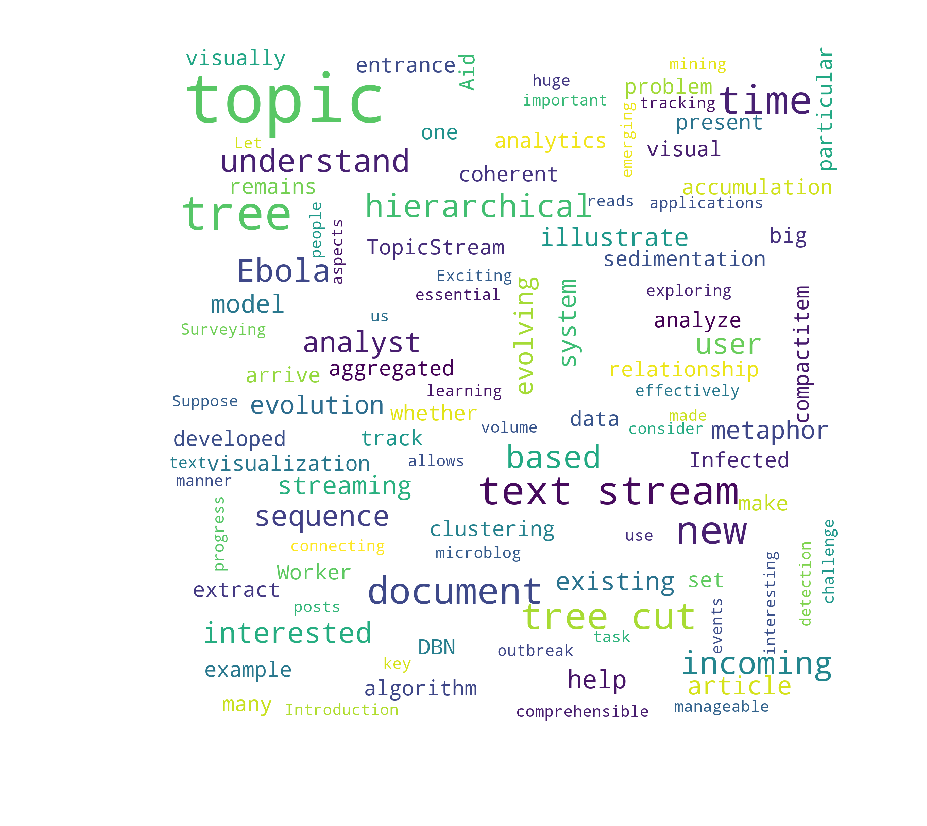

In [138]:
ShowAndSave(wc.generate_from_text(final[2][1]), 'plain')

In [115]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import cv2

mask = np.array(Image.open('data/mask.png'))
wc_fancy = WordCloud(
       background_color="white", max_words=1000, mask=mask,
               max_font_size=90, random_state=42
)

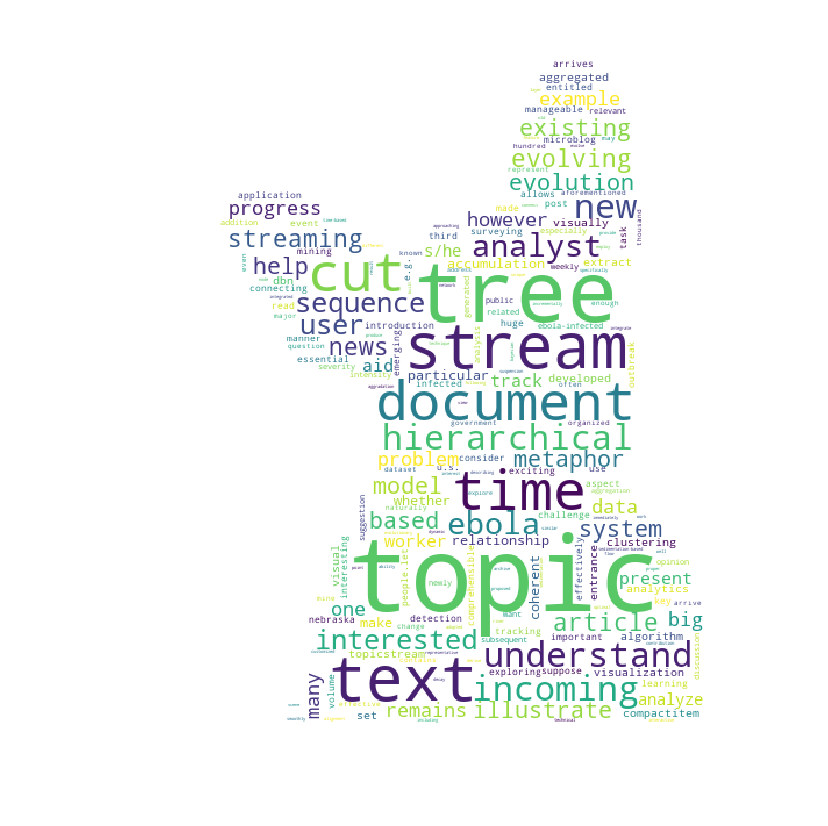

In [15]:
w = wc_fancy.generate_from_frequencies(c.passage_dic[passage_id])
ShowAndSave(pic = w, name = 'Frequent')

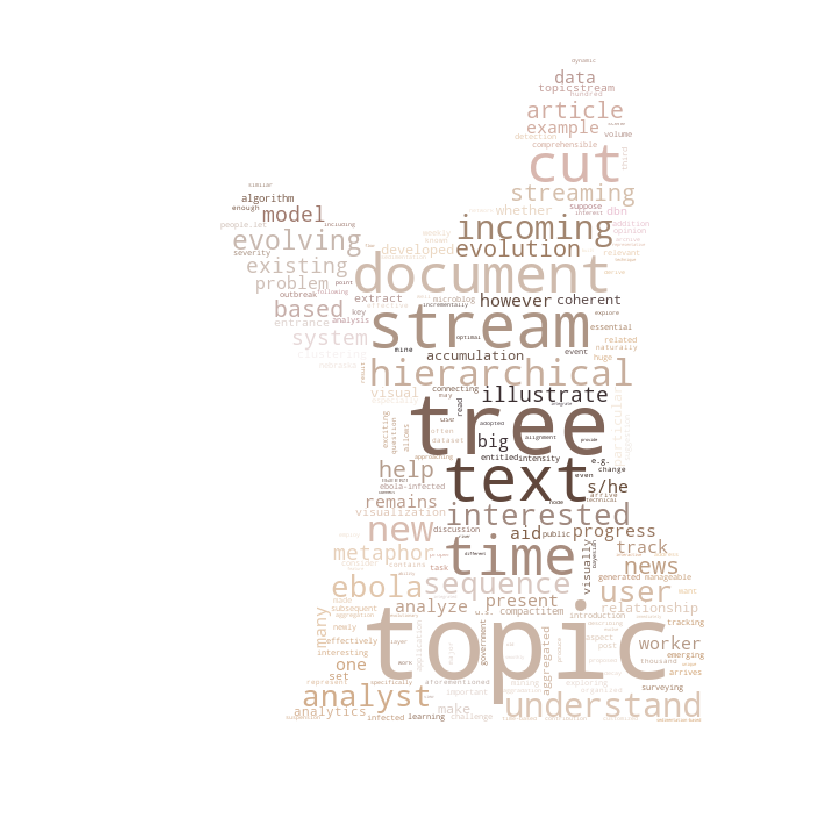

In [16]:
wc_fancy.generate_from_frequencies(c.passage_dic[passage_id])
image_colors = ImageColorGenerator(mask)
w = wc_fancy.recolor(color_func=image_colors)
ShowAndSave(w,'colorAsMask')

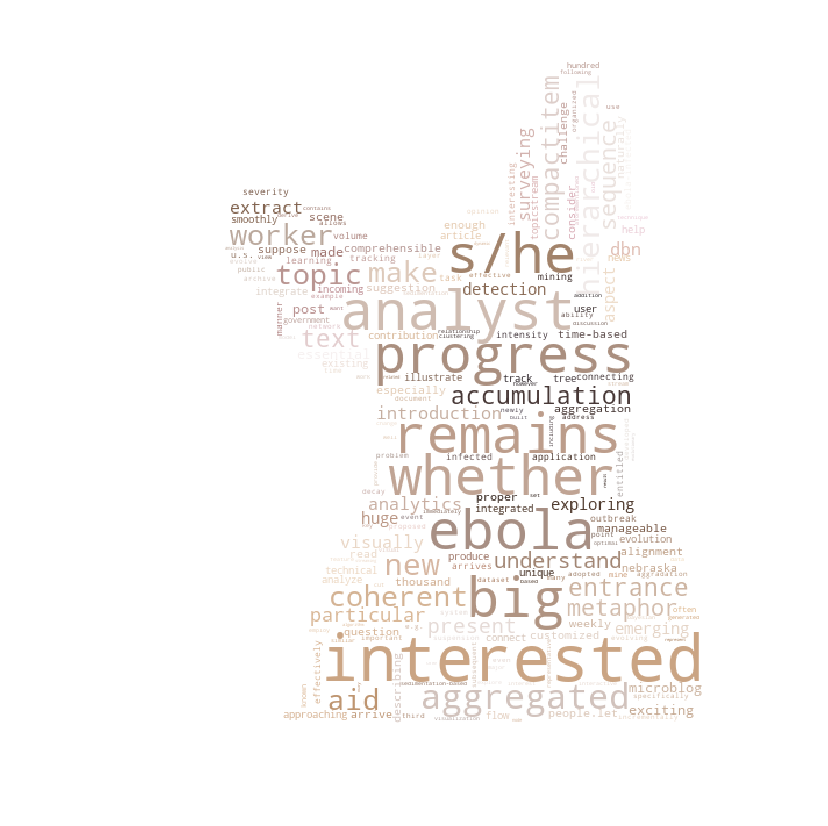

In [17]:
words = c.passage_dic[passage_id].keys()
score = {}
for w in words:
    score[w] = c.TF_IDF(w,passage_id)
wc_fancy.generate_from_frequencies(score)
image_colors = ImageColorGenerator(mask)
w = wc_fancy.recolor(color_func=image_colors)
ShowAndSave(w, 'TF_IDF')

In [18]:
# load pre-trained glove model
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = '/home/lzlzlizi/Documents/data/word2vecModel/glove.840B.300d.txt'
word2vec_output_file = '/home/lzlzlizi/Documents/data/word2vecModel/glove.840B.300d.word2vec.txt'
(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)
print(count, '\n', dimensions)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

2196017 
 300


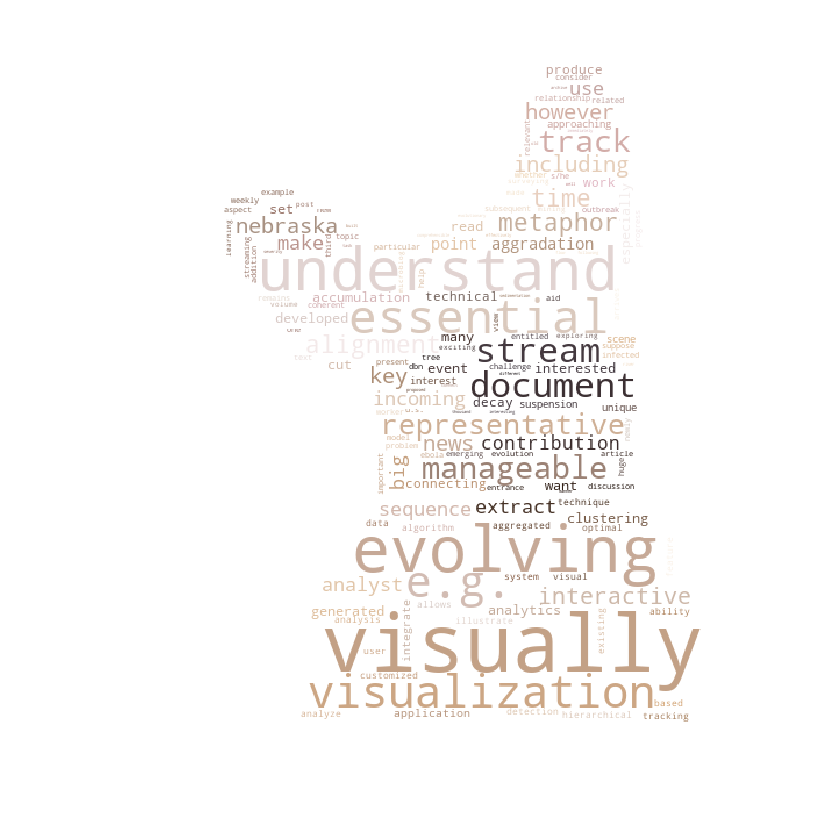

In [150]:
vecs = {}
word2id = {}
ww = list(c.passage_dic[passage_id].keys())
score = [c.passage_dic[passage_id][w] for w in ww]
words = [ww[t] for t in np.argsort(score)]
i = 0
tt = len(words) - 1
while  i < 150:
    w = words[tt]
    if w in glove_model:
        vecs[w] = glove_model[w]
        word2id[w] = i
        i += 1
    tt -= 1
words = list(vecs.keys())
for w in word2id:
    words[word2id[w]] = w
vecs = np.array([vecs[w] for w in words])
score = np.array([score[word2id[w]] for w in words])

from sklearn.cluster import SpectralClustering 
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors') 
labels_rbf = spectral_model_rbf.fit_predict(vecs) 

cut = sum(labels_rbf)/len(labels_rbf)
h,w,_ = mask.shape
a = np.copy(mask[:,:,3])
a[a!=0] = 1
t = a.sum(axis = 0)
total = sum(t) * cut
tt = 0
for i in range(h):
    if tt < total:
        tt += t[i]
    else:
        break
h1 = i


mask1 = mask[:h1,:,:]
mask2 = mask[h1:,:,:]

d1 = {}
d0 = {}
for w in words:
    if labels_rbf[word2id[w]] == 1:
        d1[w] = score[word2id[w]]
    else:
        d0[w] = score[word2id[w]]

wc_fancy1 = WordCloud(
       background_color="white", max_words=1000, mask=mask1,
               max_font_size=90, random_state=42
)
wc_fancy2 = WordCloud(
       background_color="white", max_words=1000, mask=mask2,
               max_font_size=90, random_state=42
)
w1 = wc_fancy1.generate_from_frequencies(d1)
image_colors = ImageColorGenerator(mask1)
w1.recolor(color_func=image_colors)
w2 = wc_fancy2.generate_from_frequencies(d0)
image_colors = ImageColorGenerator(mask2)
w2.recolor(color_func=image_colors)

ShowAndSave(np.r_[np.array(w1),np.array(w2)],'EmbeddingClustering')